In [ ]:
import os
import math
import keras
import pickle
import random
import imageio
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.cm as cm
from keras import regularizers
import matplotlib.pyplot as plt
from keras.utils import Sequence
from keras.optimizers import Adam
from keras import optimizers, metrics
from keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau
from keras import layers, models, applications
from sklearn.preprocessing import label_binarize
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import load_model, Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.applications import ResNet50, EfficientNetB1
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Dense, GlobalAveragePooling2D, PReLU
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, roc_auc_score, classification_report

Shape of No Substructure: (64, 64, 1)
Shape of Axion: (64, 64, 1)
Shape of Cold Dark Matter (CDM): (64, 64, 1)


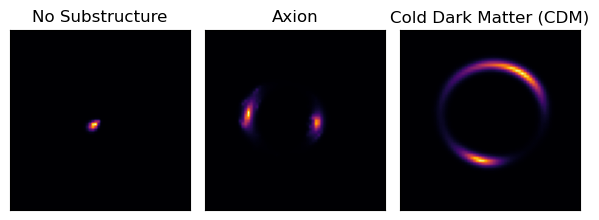

In [59]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(6, 4))

for i, (folder_path, title) in enumerate([
    ('Model_IV/no_sub', 'No Substructure'),
    ('Model_IV/axion', 'Axion'),
    ('Model_IV/cdm', 'Cold Dark Matter (CDM)')]):
    file_name = os.listdir(folder_path)[7]
    file_path = os.path.join(folder_path, file_name)
    if folder_path == 'Model_IV/axion':
        loaded_file = np.load(file_path, allow_pickle=True)[0][..., np.newaxis]
    else:
        loaded_file = np.load(file_path, allow_pickle=False)
        loaded_file = loaded_file.reshape((64, 64))[..., np.newaxis]

    print(f'Shape of {title}: {loaded_file.shape}') # Since the dataset states that 'Axion files have extra data corresponding to mass of axion used in simulation'. So the .npy file has a shape of 2, having the image and this mass.
    img_array = loaded_file
    axs[i].imshow(img_array, cmap='inferno')
    axs[i].set_title(title)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

plt.tight_layout()
plt.show()

In [3]:
# Algorithm hyperparameters
input_shape = (64, 64, 1)
num_epochs = 20
batch_size = 256 
width = 512
temperature = 0.1
queue_size = 10000

contrastive_augmentation_rotation = {"factor": 0.5,"name": "contrastive_augmenter_rotation"}
contrastive_augmentation_gaussian = {"std_dev": 0.01,"name": "contrastive_augmenter_gaussian"} # Std_dev = 0.04 for rgb and 0.001 for 1 channel


# classification_augmentation = {"brightness": 0.1,"name": "classification_augmenter","scale": (0.5, 3.0),}

# total_samples = sum([len(files) for r, d, files in os.walk(data_path)])
# steps_per_epoch = total_samples // batch_size
# validation_steps = total_samples // batch_size


In [36]:
classes = ['axion', 'cdm', 'no_sub']
class_indices = {class_name: idx for idx, class_name in enumerate(classes)}

def image_generator(files, label_type, batch_size = batch_size):
    while True:
        # Select files (paths/indices) for the batch
        batch_paths = np.random.choice(a = files, size = batch_size)
        batch_input = []
        batch_output = []

        # Read in each input, perform preprocessing and get labels
        for input_path in batch_paths:
            class_name = os.path.basename(os.path.dirname(input_path))
            label = class_indices[class_name] 
            if class_name == 'axion':
                input = np.load(input_path, allow_pickle=True)[0][..., np.newaxis]
            else:
                input = np.load(input_path, allow_pickle=False).reshape((64, 64))[..., np.newaxis]

#             img_3d = np.repeat(input, 3, axis=-1) # For RGB channel
#             img_3d  = (img_3d - np.min(img_3d)) / (np.max(img_3d) - np.min(img_3d)) # For RGB channel
#             batch_input += [ img_3d ] # For RGB channel
            batch_input += [ input ] # For Single channel
            batch_output += [ label ]
    
        batch_x = np.array(batch_input)
        if label_type == 'one_hot':
            batch_y = to_categorical(batch_output, num_classes=3)  # Perform one-hot encoding
        elif label_type == 'label':
            batch_y = np.array(batch_output)
        # print(batch_x.shape,batch_y.shape)
        yield(batch_x, batch_y)

# Get all file paths in the data_path
data_path = 'Model_IV/' 
file_paths = []
for class_name in classes:
    class_dir = os.path.join(data_path, class_name)
    file_paths += [os.path.join(class_dir, file) for file in os.listdir(class_dir)]


train_files, test_files = train_test_split(file_paths, test_size=0.1, random_state=15)

train_generator_one_hot = image_generator(train_files, label_type = 'one_hot', batch_size=batch_size)
test_generator_one_hot = image_generator(test_files, label_type = 'one_hot', batch_size=batch_size)

train_generator_label = image_generator(train_files,label_type = 'label',  batch_size=batch_size)
test_generator_label = image_generator(test_files,label_type = 'label',  batch_size=batch_size)

total_samples = len(train_files)
steps_per_epoch = total_samples // batch_size
total_validation_samples = len(test_files)
validation_steps = total_validation_samples // batch_size

Array Range: 4.50098826118068e-06, 50.63314177143738
Sample Image of label axion: 


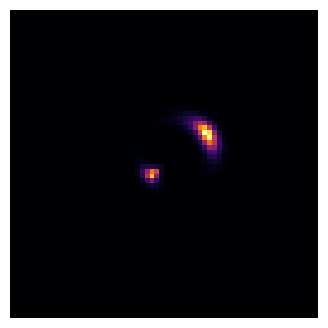

Image shape: (256, 64, 64, 1)
Label shape: (256, 3)


In [85]:
image_sample, label_sample = next(train_generator_one_hot)
print(f'Array Range: {np.min(image_sample[0])}, {np.max(image_sample[0])}')
print(f'Sample Image of label {"axion" if np.argmax(label_sample[0]) == 0 else "cdm" if np.argmax(label_sample[0]) == 1 else "no_sub"}: ')
plt.figure(figsize=(4,4))
plt.imshow(image_sample[0], cmap='inferno') # np.mean(image_sample[0], axis=2) is used to convert the rgb image to greyscale so we can apply cmap to it.
plt.axis('off')
plt.show()
print(f'Image shape: {image_sample.shape}\nLabel shape: {label_sample.shape}')


In [5]:
class RandomResizedCrop(layers.Layer):
    def __init__(self, scale, ratio):
        super().__init__()
        self.scale = scale
        self.log_ratio = (tf.math.log(ratio[0]), tf.math.log(ratio[1]))

    def call(self, images):
        batch_size = tf.shape(images)[0]
        height = tf.shape(images)[1]
        width = tf.shape(images)[2]

        random_scales = tf.random.uniform((batch_size,), self.scale[0], self.scale[1])
        random_ratios = tf.exp(
            tf.random.uniform((batch_size,), self.log_ratio[0], self.log_ratio[1])
        )

        new_heights = tf.clip_by_value(tf.sqrt(random_scales / random_ratios), 0, 1)
        new_widths = tf.clip_by_value(tf.sqrt(random_scales * random_ratios), 0, 1)
        height_offsets = tf.random.uniform((batch_size,), 0, 1 - new_heights)
        width_offsets = tf.random.uniform((batch_size,), 0, 1 - new_widths)

        bounding_boxes = tf.stack(
            [
                height_offsets,
                width_offsets,
                height_offsets + new_heights,
                width_offsets + new_widths,
            ],
            axis=1,
        )
        images = tf.image.crop_and_resize(
            images, bounding_boxes, tf.range(batch_size), (height, width)
        )
        return images
    
class RandomGaussianNoise(layers.Layer):
    def __init__(self, std_dev):
        super().__init__()
        self.std_dev = std_dev

    def add_gaussian_noise(self, images):
        noise = tf.random.normal(shape=tf.shape(images), mean=0., stddev=self.std_dev)
        return tf.clip_by_value(images + noise, 0, 1)

    def call(self, images):
        images = self.add_gaussian_noise(images)
        return images

    
    
def get_augmenter_only_gaussian(std_dev, name):
    return keras.Sequential(
        [
            layers.Input(shape=input_shape),
            layers.Rescaling(1 / 255), # Only for Single Channel Images
#             layers.RandomRotation(1), # Not needed for now
            RandomGaussianNoise(std_dev=std_dev),
#             RandomResizedCrop(scale=scale, ratio=(3 / 4, 4 / 3)),
#             RandomBrightness(brightness=brightness),
        ],
        name=name,)

def get_augmenter_only_rotation(factor, name):
    return keras.Sequential(
        [
            layers.Input(shape=input_shape),
            layers.Rescaling(1 / 255), # Only for Single Channel Images
            layers.RandomRotation(factor), 
        ],
        name=name,)

class RandomBrightness(layers.Layer):
    def __init__(self, brightness):
        super().__init__()
        self.brightness = brightness
    def blend(self, images_1, images_2, ratios):
        return tf.clip_by_value(ratios * images_1 + (1.0 - ratios) * images_2, 0, 1)
    def random_brightness(self, images):
        # random interpolation/extrapolation between the image and darkness
        return self.blend(
            images,
            0,
            tf.random.uniform(
                (tf.shape(images)[0], 1, 1, 1), 1 - self.brightness, 1 + self.brightness),)
    def call(self, images):
        images = self.random_brightness(images)
        return images 

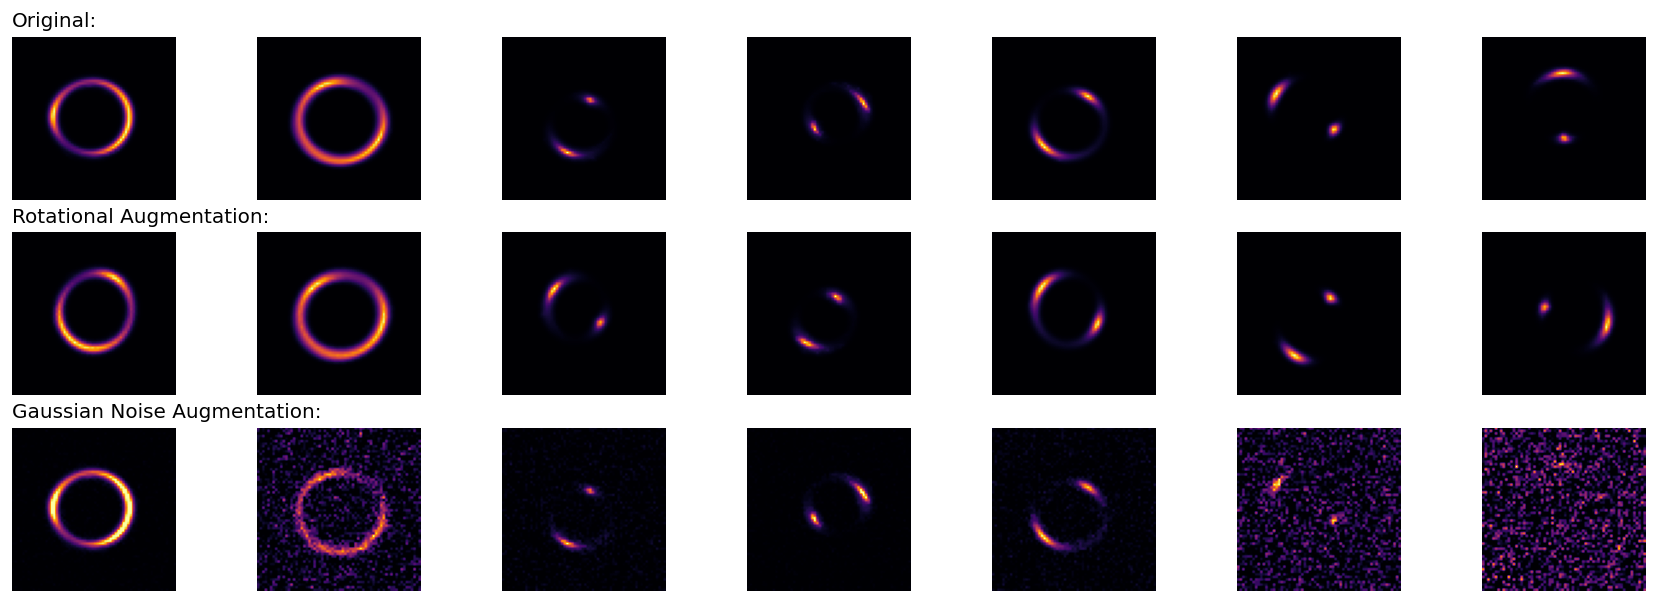

In [87]:
def visualize_augmentations(num_images):
    # Sample a batch from a dataset
    images = next(train_generator_one_hot)[0][:num_images]
    augmented_images = zip(
        images,
        get_augmenter_only_rotation(**contrastive_augmentation_rotation)(images),
        get_augmenter_only_gaussian(**contrastive_augmentation_gaussian)(images),
    )
    row_titles = [
        "Original:",
        "Rotational Augmentation:",
        "Gaussian Noise Augmentation:",
    ]
    plt.figure(figsize=(18, 6), dpi=120)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(3, num_images, row * num_images + column + 1)
            plt.imshow(image, cmap='inferno') #np.mean(image, axis=2) for RGB Images
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")

visualize_augmentations(num_images=7)

### Baseline Training


In [6]:
def get_encoder():
    resnet = applications.ResNet50(weights=None, include_top=False, input_shape=input_shape)
#     for layer in resnet.layers:
#         layer.trainable = False
    model = models.Sequential([
          resnet,
          layers.GlobalAveragePooling2D(),
          layers.Dense(width*8,  activation='relu'), #256*8 = 2048
          layers.BatchNormalization(), 
          layers.Dropout(0.5),
        
          layers.Dense(width*4,  activation='relu'), #256*4 = 1024
          layers.BatchNormalization(),
          layers.Dropout(0.5),
        
          layers.Dense(width,  activation='relu'), #512
          layers.BatchNormalization(),
          layers.Dropout(0.3),
    ])
    return model


In [89]:
baseline_model = keras.Sequential(
    [ 
        get_encoder(),
        layers.Dense(3, activation='softmax'),
    ],
    name="baseline_model",
)
baseline_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate= 1e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['acc', metrics.AUC(name='auc')])

baseline_history = baseline_model.fit(train_generator_one_hot, steps_per_epoch=steps_per_epoch, epochs=num_epochs, 
                                      validation_data=test_generator_one_hot, validation_steps = validation_steps)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_history.history["val_acc"]) * 100
    )
)

Epoch 1/20
132/132 [==============================] - 261s 2s/step - loss: 1.4248 - acc: 0.3552 - auc: 0.5223 - val_loss: 1.0787 - val_acc: 0.4799 - val_auc: 0.5532
Epoch 2/20
132/132 [==============================] - 130s 993ms/step - loss: 1.2447 - acc: 0.3990 - auc: 0.5777 - val_loss: 1.0477 - val_acc: 0.4780 - val_auc: 0.6589
Epoch 3/20
132/132 [==============================] - 89s 679ms/step - loss: 1.1791 - acc: 0.4260 - auc: 0.6169 - val_loss: 1.0610 - val_acc: 0.5020 - val_auc: 0.6816
Epoch 4/20
132/132 [==============================] - 75s 567ms/step - loss: 1.1306 - acc: 0.4411 - auc: 0.6370 - val_loss: 1.0144 - val_acc: 0.4710 - val_auc: 0.6653
Epoch 5/20
132/132 [==============================] - 73s 555ms/step - loss: 1.1187 - acc: 0.4396 - auc: 0.6385 - val_loss: 1.0110 - val_acc: 0.4166 - val_auc: 0.6471
Epoch 6/20
132/132 [==============================] - 72s 545ms/step - loss: 1.1098 - acc: 0.4440 - auc: 0.6429 - val_loss: 1.0000 - val_acc: 0.4894 - val_auc: 0.6742

In [90]:
baseline_model.save_weights('baseline_model_resnet50.h5')
# loaded_model = ContrastiveModel()
# pretraining_model.load_weights('pretraining_model.h5')
with open('baseline_history_resnet50.pkl', 'wb') as file:
    pickle.dump(baseline_history.history, file)

### Self-Supervised Contrastive Pretraining


c_loss: Contrastive loss. It is a measure of dissimilarity between pairs of augmented images. This loss is calculated using the InfoNCE (Information Noise-Contrastive Estimation) or NT-Xent (Normalized Temperature-Scaled Cross Entropy) loss, which encourages similar representations for augmented views of the same image and dissimilar representations for different images.

c_acc: Contrastive accuracy. It measures the accuracy of the contrastive predictions. In this case, it represents how well the model is able to distinguish between the representations of augmented views of the same image and different images.

p_loss: Probe loss. It is the loss for the linear probe, which is used for evaluation and downstream classification tasks. The probe loss is calculated using the sparse categorical cross-entropy loss, comparing the predicted class probabilities with the true labels.

p_acc: Probe accuracy. It represents the accuracy of the linear probe, indicating how well the model performs on the downstream classification task.

### With only Rotational

In [91]:
# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter_only_rotation(**contrastive_augmentation_rotation)
        self.encoder = get_encoder()
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(3)], name="linear_probe"
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
            name="c_acc"
        )
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, tf.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        labeled_images, labels = data

        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(labeled_images)
        augmented_images_2 = self.contrastive_augmenter(labeled_images)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
#         preprocessed_images = self.classification_augmenter(
#             labeled_images, training=True
#         )
        
        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(labeled_images, training=False) #preprocessed_images replaced with labeled_images
            class_logits = self.linear_probe(features, training=True)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
#         preprocessed_images = self.classification_augmenter(
#             labeled_images, training=False
#         )
        features = self.encoder(labeled_images, training=False) #preprocessed_images replaced with labeled_images
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}


# Contrastive pretraining
pretraining_model = ContrastiveModel()
pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

pretraining_history = pretraining_model.fit(train_generator_label, steps_per_epoch=steps_per_epoch, epochs=num_epochs, 
                                            validation_data=test_generator_label, validation_steps = validation_steps)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history.history["val_p_acc"]) * 100
    )
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23581440  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 4096)              8392704   
                                                                 
 batch_normalization_3 (Batc  (None, 4096)             16384     
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 4096)              0         
                                                                 
 dense_5 (Dense)             (None, 2048)             

In [92]:
pretraining_model.save_weights('pretraining_model_rotational.h5')
with open('pretraining_history_rotational.pkl', 'wb') as file:
    pickle.dump(pretraining_history.history, file)

In [93]:
finetuning_model_rotation = keras.Sequential(
    [
        pretraining_model.encoder,
        layers.Dense(3, activation='softmax'),
    ],
    name="finetuning_model_rotation",
)
finetuning_model_rotation.compile(
    optimizer=keras.optimizers.Adam(learning_rate= 1e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['acc', metrics.AUC(name='auc')])

finetuning_history_rotation = finetuning_model_rotation.fit(train_generator_one_hot, steps_per_epoch=steps_per_epoch, epochs=num_epochs, 
                                          validation_data=test_generator_one_hot, validation_steps = validation_steps)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history_rotation.history["val_acc"]) * 100
    )
)

Epoch 1/20
132/132 [==============================] - 73s 502ms/step - loss: 1.3219 - acc: 0.3606 - auc: 0.5326 - val_loss: 1.0605 - val_acc: 0.4434 - val_auc: 0.6528
Epoch 2/20
132/132 [==============================] - 62s 474ms/step - loss: 1.1952 - acc: 0.4116 - auc: 0.5986 - val_loss: 1.1032 - val_acc: 0.4732 - val_auc: 0.6636
Epoch 3/20
132/132 [==============================] - 67s 507ms/step - loss: 1.1693 - acc: 0.4249 - auc: 0.6213 - val_loss: 1.0920 - val_acc: 0.4383 - val_auc: 0.6487
Epoch 4/20
132/132 [==============================] - 67s 508ms/step - loss: 1.1484 - acc: 0.4294 - auc: 0.6271 - val_loss: 1.5384 - val_acc: 0.4819 - val_auc: 0.6584
Epoch 5/20
132/132 [==============================] - 63s 478ms/step - loss: 1.1446 - acc: 0.4318 - auc: 0.6309 - val_loss: 1.0058 - val_acc: 0.4699 - val_auc: 0.6575
Epoch 6/20
132/132 [==============================] - 63s 479ms/step - loss: 1.1183 - acc: 0.4399 - auc: 0.6391 - val_loss: 1.0158 - val_acc: 0.4799 - val_auc: 0.673

In [94]:
finetuning_model_rotation.save_weights('finetuning_model_rotation.h5')
# loaded_model = ContrastiveModel()
# pretraining_model.load_weights('pretraining_model.h5')
with open('finetuning_history_rotation.pkl', 'wb') as file:
    pickle.dump(finetuning_history_rotation.history, file)

### With Gaussian blur

In [95]:
# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.contrastive_augmenter = get_augmenter_only_gaussian(**contrastive_augmentation_gaussian)
        self.encoder = get_encoder()
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(3)], name="linear_probe"
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        # self.contrastive_loss will be defined as a method
        self.probe_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

        self.contrastive_loss_tracker = keras.metrics.Mean(name="c_loss")
        self.contrastive_accuracy = keras.metrics.SparseCategoricalAccuracy(
            name="c_acc"
        )
        self.probe_loss_tracker = keras.metrics.Mean(name="p_loss")
        self.probe_accuracy = keras.metrics.SparseCategoricalAccuracy(name="p_acc")

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_loss(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, tf.transpose(similarities)
        )

        # The temperature-scaled similarities are used as logits for cross-entropy
        # a symmetrized version of the loss is used here
        loss_1_2 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, similarities, from_logits=True
        )
        loss_2_1 = keras.losses.sparse_categorical_crossentropy(
            contrastive_labels, tf.transpose(similarities), from_logits=True
        )
        return (loss_1_2 + loss_2_1) / 2

    def train_step(self, data):
        labeled_images, labels = data

        # Each image is augmented twice, differently
        augmented_images_1 = self.contrastive_augmenter(labeled_images)
        augmented_images_2 = self.contrastive_augmenter(labeled_images)
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)
            contrastive_loss = self.contrastive_loss(projections_1, projections_2)
        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
#         preprocessed_images = self.classification_augmenter(
#             labeled_images, training=True
#         )
        
        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(labeled_images, training=False) #preprocessed_images replaced with labeled_images
            class_logits = self.linear_probe(features, training=True)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
#         preprocessed_images = self.classification_augmenter(
#             labeled_images, training=False
#         )
        features = self.encoder(labeled_images, training=False) #preprocessed_images replaced with labeled_images
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}


# Contrastive pretraining
pretraining_model_gaussian = ContrastiveModel()
pretraining_model_gaussian.compile(
    contrastive_optimizer=keras.optimizers.Adam(),
    probe_optimizer=keras.optimizers.Adam(),
)

pretraining_history_gaussian = pretraining_model_gaussian.fit(train_generator_label, steps_per_epoch=steps_per_epoch, epochs=num_epochs, 
                                            validation_data=test_generator_label, validation_steps = validation_steps)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history_gaussian.history["val_p_acc"]) * 100
    )
)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23581440  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_11 (Dense)            (None, 4096)              8392704   
                                                                 
 batch_normalization_6 (Batc  (None, 4096)             16384     
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 4096)              0         
                                                                 
 dense_12 (Dense)            (None, 2048)             

In [96]:
pretraining_model_gaussian.save_weights('pretraining_model_gaussian.h5')
with open('pretraining_history_gaussian.pkl', 'wb') as file:
    pickle.dump(pretraining_history_gaussian.history, file)


In [97]:
finetuning_model_gaussian = keras.Sequential(
    [
        pretraining_model_gaussian.encoder,
        layers.Dense(3, activation='softmax'),
    ],
    name="finetuning_model",
)
finetuning_model_gaussian.compile(
    optimizer=keras.optimizers.Adam(learning_rate= 1e-4),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['acc', metrics.AUC(name='auc')])

finetuning_history_gaussian = finetuning_model_gaussian.fit(train_generator_one_hot, steps_per_epoch=steps_per_epoch, epochs=num_epochs, 
                                          validation_data=test_generator_one_hot, validation_steps = validation_steps)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history_gaussian.history["val_acc"]) * 100
    )
)

Epoch 1/20
132/132 [==============================] - 74s 507ms/step - loss: 1.2655 - acc: 0.4016 - auc: 0.5799 - val_loss: 1.0107 - val_acc: 0.4353 - val_auc: 0.6587
Epoch 2/20
132/132 [==============================] - 67s 511ms/step - loss: 1.1604 - acc: 0.4307 - auc: 0.6289 - val_loss: 1.0171 - val_acc: 0.4746 - val_auc: 0.6626
Epoch 3/20
132/132 [==============================] - 66s 504ms/step - loss: 1.1306 - acc: 0.4448 - auc: 0.6438 - val_loss: 1.0491 - val_acc: 0.4964 - val_auc: 0.6823
Epoch 4/20
132/132 [==============================] - 68s 518ms/step - loss: 1.1285 - acc: 0.4436 - auc: 0.6420 - val_loss: 1.0285 - val_acc: 0.4707 - val_auc: 0.6616
Epoch 5/20
132/132 [==============================] - 69s 526ms/step - loss: 1.1077 - acc: 0.4470 - auc: 0.6469 - val_loss: 1.0284 - val_acc: 0.4785 - val_auc: 0.6682
Epoch 6/20
132/132 [==============================] - 66s 498ms/step - loss: 1.1106 - acc: 0.4443 - auc: 0.6462 - val_loss: 1.0266 - val_acc: 0.4721 - val_auc: 0.664

In [98]:
finetuning_model_gaussian.save_weights('finetuning_model_gaussian.h5')
with open('finetuning_history_gaussian.pkl', 'wb') as file:
    pickle.dump(finetuning_history_gaussian.history, file)


### Results

In [12]:
with open("baseline_history_resnet50.pkl", "rb") as f:
    baseline_history = pickle.load(f)
with open("finetuning_history_rotation.pkl", "rb") as f:
    finetuning_history_rotation = pickle.load(f)
with open("finetuning_history_gaussian.pkl", "rb") as f:
    finetuning_history_gaussian = pickle.load(f)   

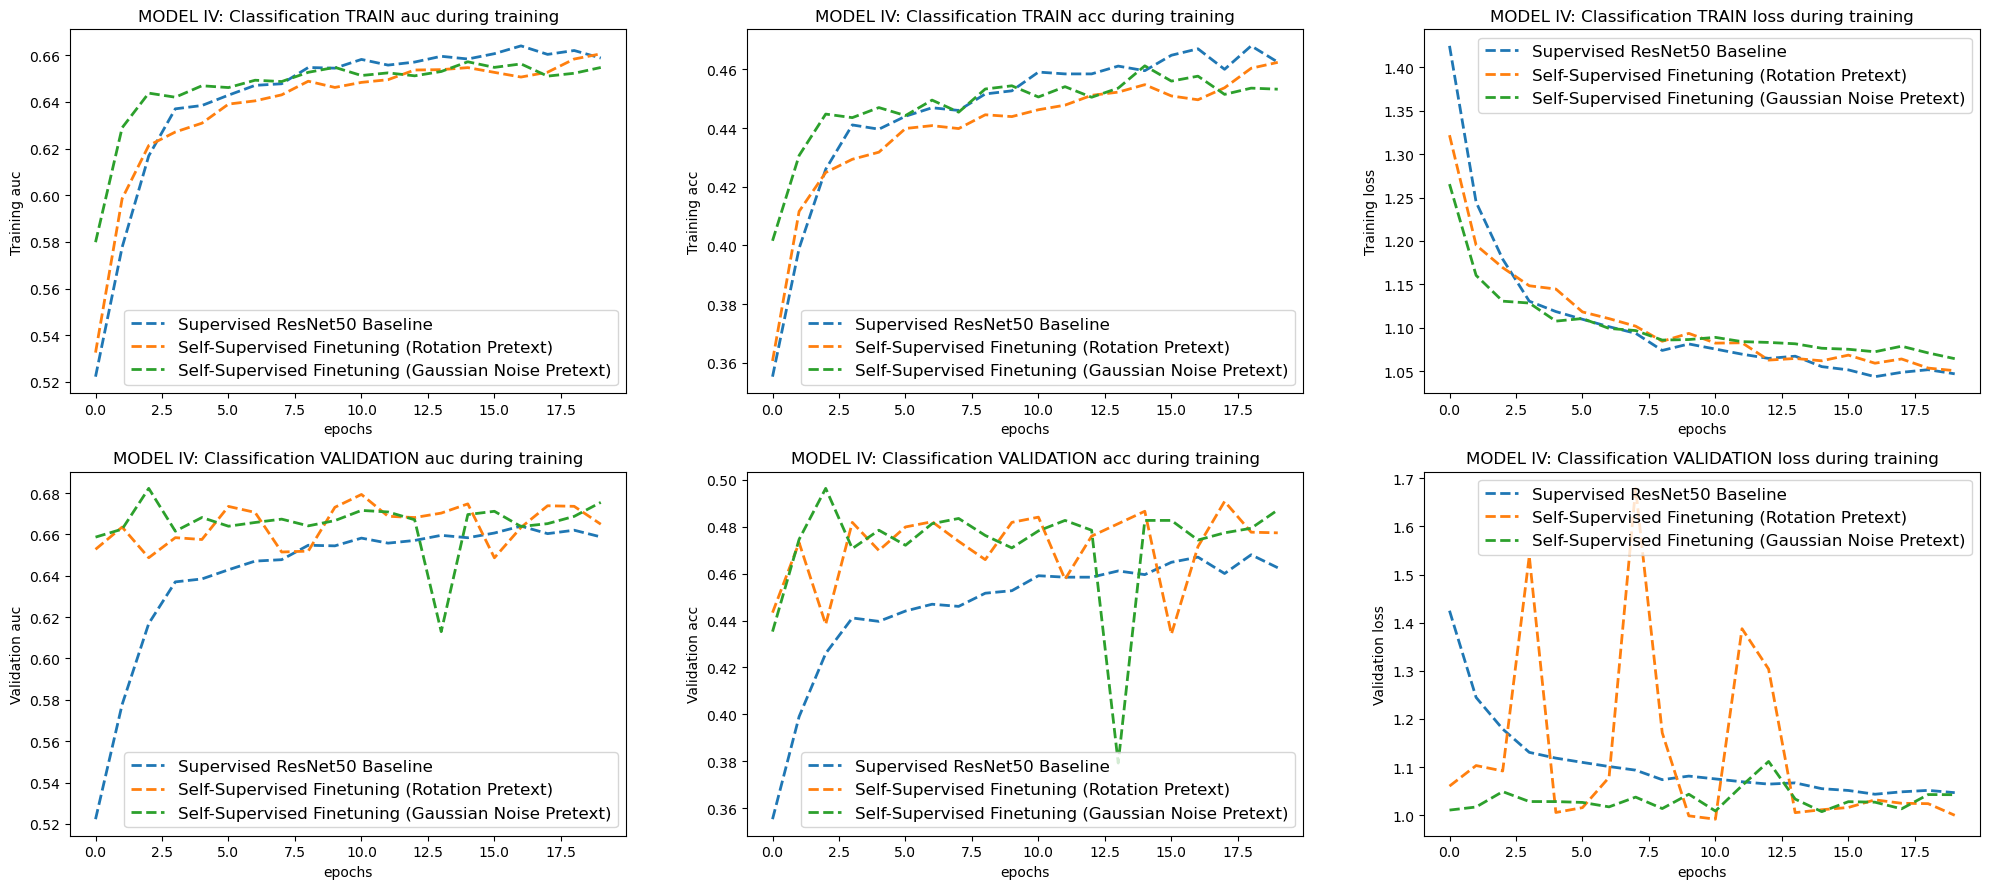

In [14]:
def plot_training_curves(baseline_history, finetuning_history_rotation, finetuning_history_gaussian):
    fig, axes = plt.subplots(2, 3, figsize=(20, 9), dpi=100)
    
    metric_keys = ["auc", "acc", "loss"]
    metric_names = ["auc", "acc", "loss"]
    
    # Plotting for MODEL IV Training
    for i, (metric_key, metric_name) in enumerate(zip(metric_keys, metric_names)):
        axes[0,i].plot(baseline_history[f"{metric_key}"], label="Supervised ResNet50 Baseline", linestyle='--', linewidth=2)
        axes[0,i].plot(finetuning_history_rotation[f"{metric_key}"], label="Self-Supervised Finetuning (Rotation Pretext)", linestyle='--', linewidth=2)
        axes[0,i].plot(finetuning_history_gaussian[f"{metric_key}"], label="Self-Supervised Finetuning (Gaussian Noise Pretext)", linestyle='--', linewidth=2)

        axes[0,i].legend(fontsize='large')
        axes[0,i].set_title(f"MODEL IV: Classification TRAIN {metric_name} during training")
        axes[0,i].set_xlabel("epochs")
        axes[0,i].set_ylabel(f"Training {metric_name}")

    # Plotting for MODEL IV Validation
    for i, (metric_key, metric_name) in enumerate(zip(metric_keys, metric_names)):
        axes[1,i].plot(baseline_history[f"{metric_key}"], label="Supervised ResNet50 Baseline", linestyle='--', linewidth=2)
        axes[1,i].plot(finetuning_history_rotation[f"val_{metric_key}"], label="Self-Supervised Finetuning (Rotation Pretext)", linestyle='--', linewidth=2)
        axes[1,i].plot(finetuning_history_gaussian[f"val_{metric_key}"], label="Self-Supervised Finetuning (Gaussian Noise Pretext)", linestyle='--', linewidth=2)

        axes[1,i].legend(fontsize='large')
        axes[1,i].set_title(f"MODEL IV: Classification VALIDATION {metric_name} during training")
        axes[1,i].set_xlabel("epochs")
        axes[1,i].set_ylabel(f"Validation {metric_name}")
    
    plt.tight_layout()
    plt.show()

plot_training_curves(baseline_history, finetuning_history_rotation, finetuning_history_gaussian)

In [38]:
baseline_model.load_weights('baseline_model_resnet50.h5')
finetuning_model_rotation.load_weights('finetuning_model_rotation.h5')
finetuning_model_gaussian.load_weights('finetuning_model_gaussian.h5')

In [27]:
# val_file_paths = []
# for class_name in classes:
# #     val_class_dir = os.path.join('Model_II_test/' , class_name)
#     val_class_dir = os.path.join('Model_IV' , class_name)
#     val_file_paths += [os.path.join(val_class_dir, file) for file in os.listdir(val_class_dir)]
# val_generator = image_generator(val_file_paths, label_type='one_hot', batch_size = batch_size)

# # baseline_model_results = baseline_model.predict(val_generator, steps=len(val_file_paths), verbose=1)
# # finetuning_model_rotation_results = finetuning_model_rotation.predict(val_generator, steps=len(val_file_paths), verbose=1)
# # finetuning_model_gaussian_results = finetuning_model_gaussian.predict(val_generator, steps=len(val_file_paths), verbose=1)

In [ ]:
num_batches = len(test_files) // batch_size

y_true_baseline = []
y_pred_baseline = []
y_true_finetuning_rotation = []
y_pred_finetuning_rotation = []
y_true_finetuning_gaussian = []
y_pred_finetuning_gaussian = []

for i in range(num_batches):
    X_batch, y_batch = next(test_generator_one_hot)
    y_true_baseline.extend(y_batch)
    y_pred_baseline.extend(baseline_model.predict(X_batch))
    y_true_finetuning_rotation.extend(y_batch)
    y_pred_finetuning_rotation.extend(finetuning_model_rotation.predict(X_batch))
    y_true_finetuning_gaussian.extend(y_batch)
    y_pred_finetuning_gaussian.extend(finetuning_model_gaussian.predict(X_batch))

# Here is the extra logic for handling the last smaller batch
if len(test_files) % batch_size != 0:
    X_batch, y_batch = next(test_generator_one_hot)
    y_true_baseline.extend(y_batch)
    y_pred_baseline.extend(baseline_model.predict(X_batch))
    y_true_finetuning_rotation.extend(y_batch)
    y_pred_finetuning_rotation.extend(finetuning_model_rotation.predict(X_batch))
    y_true_finetuning_gaussian.extend(y_batch)
    y_pred_finetuning_gaussian.extend(finetuning_model_gaussian.predict(X_batch))

y_true_baseline = np.array(y_true_baseline)
y_pred_baseline = np.array(y_pred_baseline)
y_true_finetuning_rotation = np.array(y_true_finetuning_rotation)
y_pred_finetuning_rotation = np.array(y_pred_finetuning_rotation)
y_true_finetuning_gaussian = np.array(y_true_finetuning_gaussian)
y_pred_finetuning_gaussian = np.array(y_pred_finetuning_gaussian)

In [45]:
# Convert one hot encoded labels back to single integer labels for accuracy and classification report
y_true_baseline_int = np.argmax(y_true_baseline, axis=1)
y_pred_baseline_int = np.argmax(y_pred_baseline, axis=1)
y_true_finetuning_rotation_int = np.argmax(y_true_finetuning_rotation, axis=1)
y_pred_finetuning_rotation_int = np.argmax(y_pred_finetuning_rotation, axis=1)
y_true_finetuning_gaussian_int = np.argmax(y_true_finetuning_gaussian, axis=1)
y_pred_finetuning_gaussian_int = np.argmax(y_pred_finetuning_gaussian, axis=1)

# Calculate AUC
auc_baseline = roc_auc_score(y_true_baseline, y_pred_baseline, average='macro', multi_class='ovr')
auc_finetuning_rotation = roc_auc_score(y_true_finetuning_rotation, y_pred_finetuning_rotation, average='macro', multi_class='ovr')
auc_finetuning_gaussian = roc_auc_score(y_true_finetuning_gaussian, y_pred_finetuning_gaussian, average='macro', multi_class='ovr')

print("Separate test set results (MODEL IV: Containing 5000 samples per class):\n")
print(f"AUC (Baseline): {int(auc_baseline * 1000) / 1000}")  
print(f"AUC (Finetuning Rotation): {int(auc_finetuning_rotation * 1000) / 1000}") 
print(f"AUC (Finetuning Gaussian): {int(auc_finetuning_gaussian * 1000) / 1000}") 

# Calculate accuracy
accuracy_baseline = accuracy_score(y_true_baseline_int, y_pred_baseline_int)
accuracy_finetuning_rotation = accuracy_score(y_true_finetuning_rotation_int, y_pred_finetuning_rotation_int)
accuracy_finetuning_gaussian = accuracy_score(y_true_finetuning_gaussian_int, y_pred_finetuning_gaussian_int)

# Print classification report
print("\nMODEL IV: Classification Report (Baseline):")
print(classification_report(y_true_baseline_int, y_pred_baseline_int, zero_division=0))
print("\nMODEL IV: Classification Report (Finetuning Rotation):")
print(classification_report(y_true_finetuning_rotation_int, y_pred_finetuning_rotation_int, zero_division=0))
print("\nMODEL IV: Classification Report (Finetuning Gaussian):")
print(classification_report(y_true_finetuning_gaussian_int, y_pred_finetuning_gaussian_int, zero_division=0))

Separate test set results (MODEL IV: Containing 5000 samples per class):

AUC (Baseline): 0.509
AUC (Finetuning Rotation): 0.497
AUC (Finetuning Gaussian): 0.498

MODEL IV: Classification Report (Baseline):
              precision    recall  f1-score   support

           0       0.48      1.00      0.65      1830
           1       0.00      0.00      0.00       535
           2       0.00      0.00      0.00      1475

    accuracy                           0.48      3840
   macro avg       0.16      0.33      0.22      3840
weighted avg       0.23      0.48      0.31      3840


MODEL IV: Classification Report (Finetuning Rotation):
              precision    recall  f1-score   support

           0       0.48      1.00      0.65      1830
           1       0.00      0.00      0.00       535
           2       0.00      0.00      0.00      1475

    accuracy                           0.48      3840
   macro avg       0.16      0.33      0.22      3840
weighted avg       0.23      0

In [53]:
y_true.argmax(axis=1)

array([1, 1, 2, ..., 0, 0, 2])

In [54]:
y_pred.argmax(axis=1)

array([0, 0, 0, ..., 0, 0, 0])

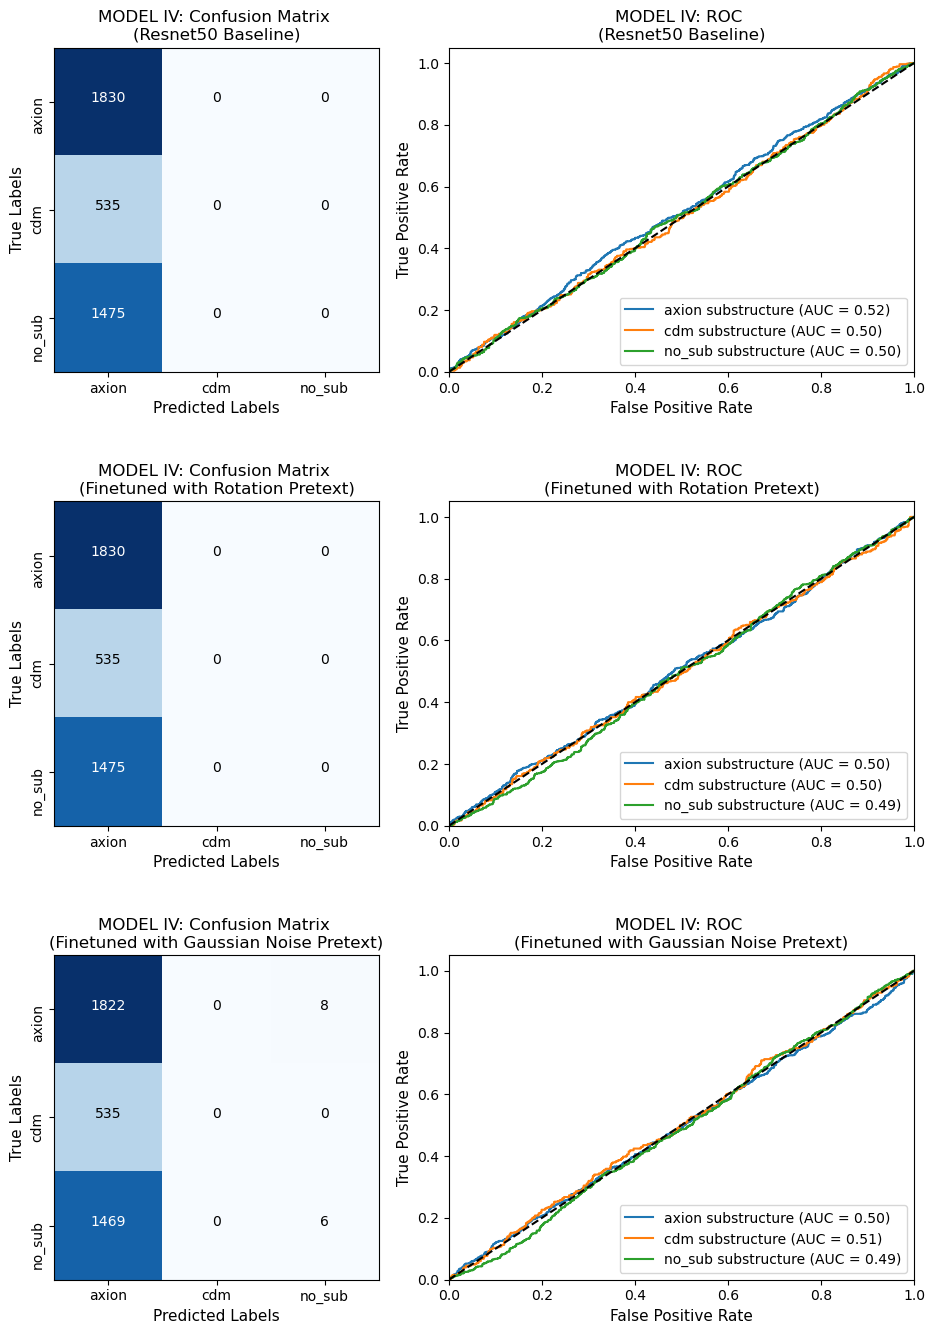

In [46]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

# Assuming these are your data variables
datasets = {
    "Resnet50 Baseline": (y_true_baseline, y_pred_baseline),
    "Finetuned with Rotation Pretext": (y_true_finetuning_rotation, y_pred_finetuning_rotation),
    "Finetuned with Gaussian Noise Pretext": (y_true_finetuning_gaussian, y_pred_finetuning_gaussian)
}

plt.figure(figsize=(12, 16)) 
for idx, (title, (y_true, y_pred)) in enumerate(datasets.items()):
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
    plt.subplot(len(datasets), 2, 2*idx+1)
    plt.imshow(cm, cmap=plt.cm.Blues)
    plt.title(f'MODEL IV: Confusion Matrix \n({title})', fontsize=12)
    plt.xlabel('Predicted Labels', fontsize=11)
    plt.ylabel('True Labels', fontsize=11)

    tick_marks = np.arange(len(class_indices))
    plt.xticks(tick_marks, class_indices)
    plt.yticks(tick_marks, class_indices, rotation=90)

    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.subplot(len(datasets), 2, 2*idx+2)
    for class_name, i in class_indices.items():
        plt.plot(fpr[i], tpr[i], label=f"{class_name} substructure (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title(f'MODEL IV: ROC \n({title})', fontsize=12)
    plt.xlabel('False Positive Rate', fontsize=11)
    plt.ylabel('True Positive Rate', fontsize=11)
    plt.legend(loc="lower right")

plt.subplots_adjust(wspace=0, hspace=0.4)
plt.show()
